### Analyze the TKE budget

In [1]:
# interactive figure
%matplotlib widget
# %matplotlib inline

In [2]:
# auto reload modules
%load_ext autoreload
%autoreload 2

import warnings
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.ticker as tkr
import matplotlib.gridspec as gridspec
from sys import platform
from xgcm import Grid
from dask.distributed import LocalCluster, Client
from IPython.display import HTML, display
from matplotlib.colors import LinearSegmentedColormap, CenteredNorm, BoundaryNorm
from viztool import FormatScalarFormatter

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

def fxn():
    warnings.warn('deprecated', DeprecationWarning)

In [3]:
if platform == 'linux' or platform == 'linux2':
    data_dir = '/glade/derecho/scratch/zhihuaz/FrontalZone/Output/'
elif platform == 'darwin':
    data_dir = '/Users/zhihua/Documents/Work/Research/Projects/TRACE-SEAS/FrontalZone/Data/'
else:
    print('OS not supported.')

### Budgets for homogeneous turbulent boundary layers

#### KE budget using resolved velocities

In [42]:
case = 'wind_center2'
# case = 'wind_weno5'
# ds = xr.open_dataset('/glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/mwe_KE_budget.nc')
ds = xr.open_dataset('/glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/mwe_KE_budget_'+case+'.nc')
ds.close()
ds['timeTf'] = ds.time/np.timedelta64(int(np.around(2*np.pi/1e-4)), 's')
ds

<xarray.Dataset> Size: 18MB
Dimensions:       (zC: 64, zF: 65, xC: 32, yF: 32, xF: 32, yC: 32, time: 4321)
Coordinates:
  * zC            (zC) float64 512B -48.76 -46.38 -44.21 ... -0.7818 -0.2606
  * zF            (zF) float64 520B -50.0 -47.51 -45.25 ... -1.042 -0.5212 0.0
  * xC            (xC) float64 256B 1.562 4.688 7.812 ... 92.19 95.31 98.44
  * yF            (yF) float64 256B 0.0 3.125 6.25 9.375 ... 90.62 93.75 96.88
  * xF            (xF) float64 256B 0.0 3.125 6.25 9.375 ... 90.62 93.75 96.88
  * yC            (yC) float64 256B 1.562 4.688 7.812 ... 92.19 95.31 98.44
  * time          (time) timedelta64[ns] 35kB 00:00:00 ... 3 days 00:00:00
Data variables:
    KE_stress     (time, zC) float64 2MB ...
    KE_tendency   (time, zC) float64 2MB ...
    KE_adv        (time, zC) float64 2MB ...
    KE_advection  (time, zC) float64 2MB ...
    KE            (time, zC) float64 2MB ...
    KE_pressure   (time, zC) float64 2MB ...
    KE_buoyancy   (time, zC) float64 2MB ...
    uh            (time, zC) float64 2MB ...
    timeTf        (time) float64 35kB 0.0 0.0009549 0.00191 ... 4.124 4.125
Attributes:
    interval:              60.0
    Oceananigans:          This file was generated using Oceananigans v0.90.14
    Julia:                 This file was generated using Julia Version 1.10.2...
    output time interval:  Output was saved every 1 minute.
    date:                  This file was generated on 2024-05-10T09:34:09.002.
    schedule:              TimeInterval

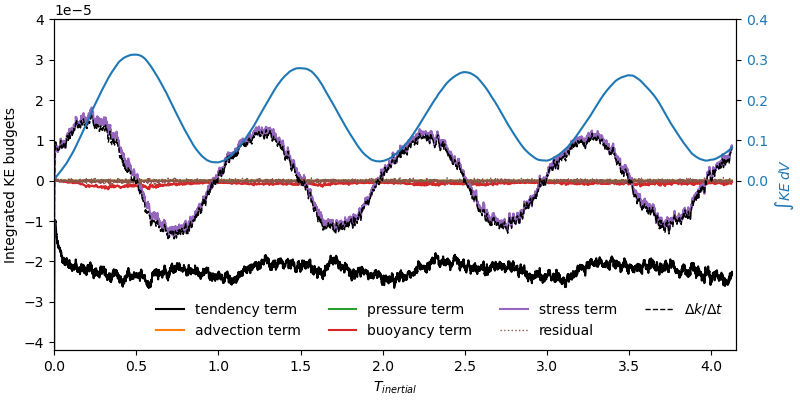

In [46]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)

# plt.plot(ds.timeTf, ds.iKE_tendency, 'k');
# plt.plot(ds.timeTf, ds.iKE_advection, 'C1');
# plt.plot(ds.timeTf, ds.iKE_pressure, 'C2');
# plt.plot(ds.timeTf, ds.iKE_buoyancy, 'C3');
# plt.plot(ds.timeTf, ds.iKE_stress, 'C4');
# plt.plot(ds.timeTf, (ds.iKE_tendency + ds.iKE_advection + ds.iKE_pressure - ds.iKE_buoyancy + ds.iKE_stress), ':C5', lw=1)

deltaz = np.diff(ds.zF)
ds['KE_stress_top'] = (ds.uh.where(ds.zC==ds.zC[-1])*(-2e-4)/deltaz[-1]).fillna(0)
ds['KE_stress_all'] =  ds.KE_stress + ds.KE_stress_top

itop = None
ds['IKE'] = (ds.KE*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_tendency'] = (ds.KE_tendency*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_advection'] = (ds.KE_advection*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_adv'] = (ds.KE_adv*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_pressure'] = (ds.KE_pressure*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_buoyancy'] = (ds.KE_buoyancy*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_stress_all'] = (ds.KE_stress_all*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_stress'] = (ds.KE_stress*deltaz).isel(zC=slice(None,itop)).sum('zC')

ds['dIKE_dt'] = ds.IKE.differentiate('time', datetime_unit='s')
ds['IKE_residual'] = ds.dIKE_dt + ds.IKE_pressure - ds.IKE_buoyancy + ds.IKE_stress_all

plt.plot(ds.timeTf,  ds.IKE_tendency, 'k');
plt.plot(ds.timeTf, -ds.IKE_advection, 'C1');
plt.plot(ds.timeTf, -ds.IKE_pressure, 'C2');
plt.plot(ds.timeTf,  ds.IKE_buoyancy, 'C3');
plt.plot(ds.timeTf, -ds.IKE_stress_all, 'C4')
plt.plot(ds.timeTf,  ds.IKE_residual, ':C5', lw=1)
plt.plot(ds.timeTf,  ds.dIKE_dt, '--k', lw=1)
plt.legend(['tendency term', 'advection term', 'pressure term', 'buoyancy term',
            'stress term', 'residual', r'$\Delta k/\Delta t$'],
           frameon=False, loc='lower right', ncol=4)
# plt.plot(ds.timeTf, -ds.IKE_adv, ':b', lw=1)
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated KE budgets')
# plt.ylim(-11e-5, 11e-5)
plt.ylim(-4.2e-5, 4e-5)
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.xlim(0,4.15)

ax1 = plt.gca().twinx()
color = 'C0'
ax1.set_ylabel(r'$\int KE \: dV$', color=color)
ax1.plot(ds.timeTf, ds.IKE, color=color)
ax1.set_yticks(np.array([0, 1, 2, 3, 4])*1e-1)
ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_ylim(-0.4, 0.4);
ax1.set_ylim(-0.42, 0.4);

# plt.savefig('../Figures/mwe_iKE_budgets_'+case, dpi=250)

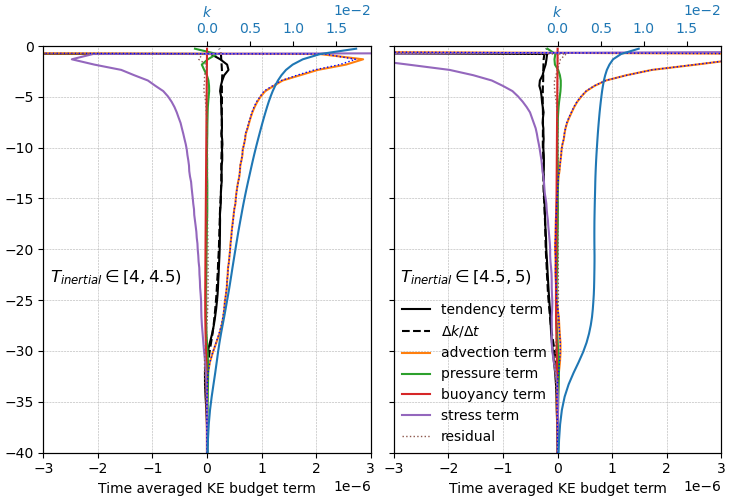

In [45]:
plt.close()
plt.figure(figsize=(7.3,5), constrained_layout=True)

plt.subplot(121)
time_interval = (ds.timeTf >= 3) & (ds.timeTf < 3.5)
ke = ds.KE.where(time_interval, drop=True).isel(time=[0,-1]).T
dkedt = ke.diff('time')/ke.time.diff('time').dt.seconds
plt.plot(ds.KE_tendency.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'k')
plt.plot(dkedt, ds.zC, '--k')
plt.plot(-ds.KE_adv.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C1')
plt.plot(-ds.KE_pressure.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C2')
plt.plot(ds.KE_buoyancy.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C3')
plt.plot(-ds.KE_stress_all.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C4')
plt.plot((ds.KE_tendency + ds.KE_adv + ds.KE_pressure - ds.KE_buoyancy +
         ds.KE_stress_all).where(time_interval).mean('time')[:itop], ds.zC[:itop], ':C5', lw=1)
plt.plot(-ds.KE_advection.where(time_interval).mean('time')[:itop], ds.zC[:itop], ':b', lw=1)
plt.text(0.02,0.42, r'$T_{inertial} \in [3,3.5)$', fontsize=12, transform=plt.gca().transAxes)
plt.grid('on', ls='--', lw=0.4)
plt.xlim(-3e-6, 3e-6)
plt.ylim(-40,0)
plt.xlabel('Time averaged KE budget term');

ax1 = plt.gca().twiny()
color = 'C0'
ax1.set_xlabel(r'$k$', color=color)
ax1.plot(ds.KE.where(time_interval).mean('time'), ds.zC, color=color)
ax1.set_xticks(np.array([0, 0.5, 1, 1.5])*1e-2)
ax1.tick_params(axis='x', labelcolor=color)
plt.ticklabel_format(axis='x', scilimits=(0,0))
ax1.set_xlim(-0.019, 0.019)

plt.subplot(122)
time_interval = (ds.timeTf >= 3.5) & (ds.timeTf < 4)
ke = ds.KE.where(time_interval, drop=True).isel(time=[0,-1]).T
dkedt = ke.diff('time')/ke.time.diff('time').dt.seconds
plt.plot(ds.KE_tendency.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'k')
plt.plot(dkedt, ds.zC, '--k')
plt.plot(-ds.KE_adv.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C1')
plt.plot(-ds.KE_pressure.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C2')
plt.plot(ds.KE_buoyancy.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C3')
plt.plot(-ds.KE_stress_all.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'C4')
plt.plot((ds.KE_tendency + ds.KE_adv + ds.KE_pressure - ds.KE_buoyancy +
         ds.KE_stress_all).where(time_interval).mean('time')[:itop], ds.zC[:itop], ':C5', lw=1)
plt.legend(['tendency term', r'$\Delta k/\Delta t$', 'advection term', 'pressure term', 'buoyancy term',
            'stress term', 'residual'], frameon=False, loc='lower left', borderpad=0.1)
plt.plot(-ds.KE_advection.where(time_interval).mean('time')[:itop], ds.zC[:itop], ':b', lw=1)
plt.text(0.02,0.42, r'$T_{inertial} \in [3.5,4)$', fontsize=12, transform=plt.gca().transAxes)
plt.gca().set_yticklabels([])
plt.grid('on', ls='--', lw=0.4)
plt.xlim(-3e-6, 3e-6)
plt.ylim(-40,0)
plt.xlabel('Time averaged KE budget term');

ax2 = plt.gca().twiny()
color = 'C0'
ax2.set_xlabel(r'$k$', color=color)
ax2.plot(ds.KE.where(time_interval).mean('time'), ds.zC, color=color)
ax2.set_xticks(np.array([0, 0.5, 1, 1.5])*1e-2)
ax2.tick_params(axis='x', labelcolor=color)
plt.ticklabel_format(axis='x', scilimits=(0,0))
ax2.set_xlim(-0.019, 0.019);

# plt.savefig('../Figures/mwe_KE_budgets_'+case, dpi=250)

#### TKE budget using perturbations from horizontal averages

In [48]:
case = 'wind_center2'
# case = 'wind_weno5'
# case = 'buoyancy_center2'
# ds = xr.open_dataset('/glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/mwe_TKE_budget.nc')
ds = xr.open_dataset('/glade/u/home/zhihuaz/Projects/TRACE-SEAS/FrontalZone/mwe_TKE_budget_'+case+'.nc')
ds.close()
ds['timeTf'] = ds.time/np.timedelta64(int(np.around(2*np.pi/1e-4)), 's')
ds

<xarray.Dataset> Size: 27MB
Dimensions:          (zC: 64, zF: 65, xC: 32, yF: 32, xF: 32, yC: 32, time: 4321)
Coordinates:
  * zC               (zC) float64 512B -48.76 -46.38 -44.21 ... -0.7818 -0.2606
  * zF               (zF) float64 520B -50.0 -47.51 -45.25 ... -0.5212 0.0
  * xC               (xC) float64 256B 1.562 4.688 7.812 ... 92.19 95.31 98.44
  * yF               (yF) float64 256B 0.0 3.125 6.25 ... 90.62 93.75 96.88
  * xF               (xF) float64 256B 0.0 3.125 6.25 ... 90.62 93.75 96.88
  * yC               (yC) float64 256B 1.562 4.688 7.812 ... 92.19 95.31 98.44
  * time             (time) timedelta64[ns] 35kB 00:00:00 ... 3 days 00:00:00
Data variables: (12/14)
    TKE_Tprs         (time, zC) float64 2MB ...
    KE               (time, zC) float64 2MB ...
    TKE              (time, zC) float64 2MB ...
    uh               (time, zC) float64 2MB ...
    KE_stress        (time, zC) float64 2MB ...
    Qu               (time) float64 35kB ...
    ...               ...
    TKE_ASP          (time, zC) float64 2MB ...
    TKE_Ttur         (time, zC) float64 2MB ...
    TKE_VBP          (time, zC) float64 2MB ...
    MKE_turbulence   (time, zC) float64 2MB ...
    TKE_dissipation  (time, zC) float64 2MB ...
    timeTf           (time) float64 35kB 0.0 0.0009549 0.00191 ... 4.124 4.125
Attributes:
    interval:              60.0
    Oceananigans:          This file was generated using Oceananigans v0.90.14
    Julia:                 This file was generated using Julia Version 1.10.2...
    output time interval:  Output was saved every 1 minute.
    date:                  This file was generated on 2024-05-05T13:00:48.006.
    schedule:              TimeInterval

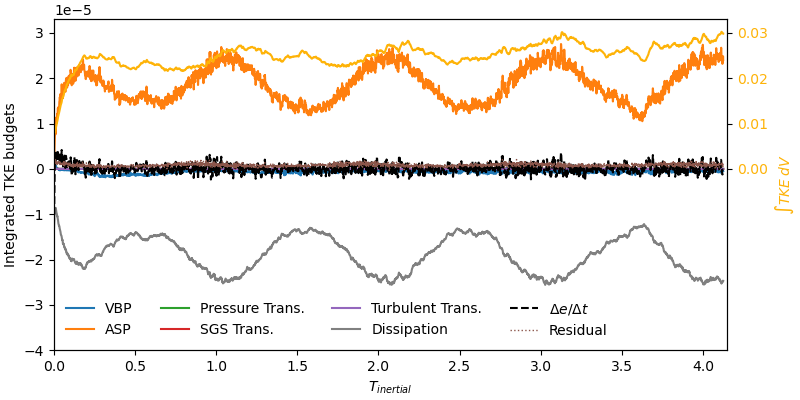

In [49]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)
time_interval = (ds.timeTf >= 0) & (ds.timeTf < 5.8)

deltaz = np.diff(ds.zF)
itop = None
ds['ITKE'] = (ds.TKE*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['ITKE_VBP'] = (ds.TKE_VBP*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['ITKE_ASP'] = (ds.TKE_ASP*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['ITKE_Tprs'] = (ds.TKE_Tprs*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['ITKE_Tsgs'] = (ds.TKE_Tsgs*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['ITKE_Ttur'] = (ds.TKE_Ttur*deltaz).isel(zC=slice(None,itop)).sum('zC')
# ds['ITKE_eps'] = (ds.TKE_eps*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['ITKE_dissipation'] = (ds.TKE_dissipation*deltaz).isel(zC=slice(None,itop)).sum('zC')
# ds['ITKE_diss0'] = (ds.TKE_diss0*deltaz).isel(zC=slice(None,itop)).sum('zC')

ds['dITKE_dt'] = ds.ITKE.differentiate('time', datetime_unit='s')
# ds['ITKE_residual'] = ds.dITKE_dt - ds.dITKE_VBP 

# plt.plot(ds.timeTf.where(time_interval), 3e-5*ds.uh.isel(zC=-1).where(time_interval));
plt.plot(ds.timeTf.where(time_interval),  ds.ITKE_VBP.where(time_interval));
plt.plot(ds.timeTf.where(time_interval),  ds.ITKE_ASP.where(time_interval));
plt.plot(ds.timeTf.where(time_interval), -ds.ITKE_Tprs.where(time_interval));
plt.plot(ds.timeTf.where(time_interval), -ds.ITKE_Tsgs.where(time_interval));
plt.plot(ds.timeTf.where(time_interval), -ds.ITKE_Ttur.where(time_interval));
# plt.plot(ds.timeTf.where(time_interval), -ds.ITKE_eps.where(time_interval), 'k')
plt.plot(ds.timeTf.where(time_interval), -ds.ITKE_dissipation.where(time_interval), 'gray')
plt.plot(ds.timeTf.where(time_interval),  ds.dITKE_dt.where(time_interval), '--k')
plt.plot(ds.timeTf.where(time_interval), (ds.dITKE_dt - (ds.ITKE_VBP + ds.ITKE_ASP - ds.ITKE_Tprs - ds.ITKE_Tsgs - ds.ITKE_Ttur -
                                          ds.ITKE_dissipation)).where(time_interval), ':', lw=1)
plt.legend(['VBP', 'ASP', 'Pressure Trans.', 'SGS Trans.', 'Turbulent Trans.',
            'Dissipation', r'$\Delta e/\Delta t$', 'Residual'],
           frameon=False, ncol=4)
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated TKE budgets')
plt.ylim(-4e-5, 3.3e-5)
# plt.ylim(-6e-6, 6e-6)
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.xlim(0,4.15)

ax1 = plt.gca().twinx()
color = 'xkcd:amber'
ax1.set_ylabel(r'$\int TKE \: dV$', color=color)
ax1.plot(ds.timeTf.where(time_interval), ds.ITKE.where(time_interval), color=color)
ax1.set_yticks(np.array([0, 1, 2, 3, 4])*1e-2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.04, 0.033);
# ax1.set_ylim(-0.033, 0.033);

# plt.savefig('../Figures/mwe_iTKE_budgets_'+case, dpi=250)

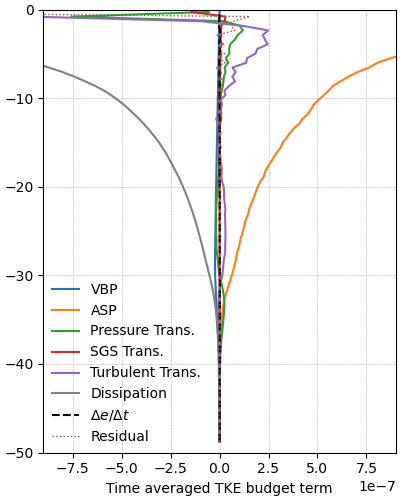

In [52]:
plt.close()
plt.figure(figsize=(4,5), constrained_layout=True)
time_interval = (ds.timeTf >= 2) & (ds.timeTf < 3)
tke = ds.TKE.where(time_interval, drop=True).isel(time=[0,-1]).T
itop = None

plt.plot(ds.TKE_VBP.where(time_interval).mean('time')[:itop], ds.zC[:itop])
plt.plot(ds.TKE_ASP.where(time_interval).mean('time')[:itop], ds.zC[:itop])
plt.plot(-ds.TKE_Tprs.where(time_interval).mean('time')[:itop], ds.zC[:itop])
plt.plot(-ds.TKE_Tsgs.where(time_interval).mean('time')[:itop], ds.zC[:itop])
# plt.plot(-(ds.TKE_Ttur + ds.TKE_Tprs + ds.TKE_Tsgs).where(time_interval).mean('time'), ds.zC)
plt.plot(-ds.TKE_Ttur.where(time_interval).mean('time')[:itop], ds.zC[:itop])
# plt.plot(-ds.TKE_eps.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'k')
plt.plot(-ds.TKE_dissipation.where(time_interval).mean('time')[:itop], ds.zC[:itop], 'gray')
plt.plot((tke.diff('time')/tke.time.diff('time').dt.seconds)[:itop], ds.zC[:itop], '--k')
plt.plot((ds.TKE_VBP + ds.TKE_ASP - ds.TKE_Tprs - ds.TKE_Tsgs - ds.TKE_Ttur -
          ds.TKE_dissipation).where(time_interval).mean('time')[:itop], ds.zC[:itop], ':', lw=1)
plt.legend(['VBP', 'ASP', 'Pressure Trans.', 'SGS Trans.', 'Turbulent Trans.',
            'Dissipation', r'$\Delta e/ \Delta t$', 'Residual'],
           frameon=False, loc='lower left', borderpad=0.1)
plt.grid('on', ls='--', lw=0.4)
plt.xlim(-0.9e-6, 0.9e-6)
# plt.xlim(-0.3e-6, 0.3e-6)
# plt.ylim(-40,0)
plt.ylim(-50,0)
plt.xlabel('Time averaged TKE budget term');

# plt.plot(ds.TKE.where(time_interval).mean('time'), ds.zC, '.-');
# plt.xlim(0.1,0.15)

# plt.savefig('../Figures/mwe_TKE_budgets_'+case, dpi=250)

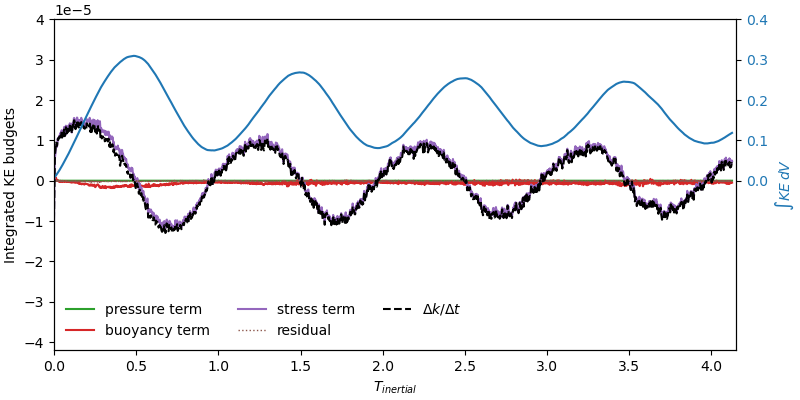

In [53]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)

deltaz = np.diff(ds.zF)
ds['KE_stress_top'] = xr.zeros_like(ds.KE_stress)
ds['KE_stress_top'] = ds.KE_stress_top.where(ds.zC != ds.zC[-1], ds.uh.isel(zC=-1)*ds.Qu/deltaz[-1])
ds['KE_stress_all'] = (ds.KE_stress + ds.KE_stress_top)

itop = None
ds['IKE'] = (ds.KE*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_pressure'] = (ds.TKE_Tprs*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_buoyancy'] = (ds.TKE_VBP*deltaz).isel(zC=slice(None,itop)).sum('zC')
ds['IKE_stress_all'] = (ds.KE_stress_all*deltaz).isel(zC=slice(None,itop)).sum('zC')

ds['dIKE_dt'] = ds.IKE.differentiate('time', datetime_unit='s')
ds['IKE_residual'] = ds.dIKE_dt + ds.IKE_pressure - ds.IKE_buoyancy + ds.IKE_stress_all

plt.plot(ds.timeTf, -ds.IKE_pressure, 'C2');
plt.plot(ds.timeTf, ds.IKE_buoyancy, 'C3');
plt.plot(ds.timeTf, -ds.IKE_stress_all, 'C4')
plt.plot(ds.timeTf, ds.IKE_residual, ':C5', lw=1)
plt.plot(ds.timeTf, ds.dIKE_dt, '--k')
plt.legend(['pressure term', 'buoyancy term',
            'stress term', 'residual', r'$\Delta k/\Delta t$'],
           frameon=False, loc='lower left', ncol=3)
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated KE budgets')
plt.ylim(-4.2e-5, 4e-5)
# plt.ylim(-6e-6, 6e-6)
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.xlim(0,4.15)

ax1 = plt.gca().twinx()
color = 'C0'
ax1.set_ylabel(r'$\int KE \: dV$', color=color)
ax1.plot(ds.timeTf, ds.IKE, color=color)
ax1.set_yticks(np.array([0, 1, 2, 3, 4])*1e-1)
# ax1.set_yticks(np.array([0, 1, 2, 3, 4])*1e-2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.42, 0.4);
# ax1.set_ylim(-0.04, 0.04);

# plt.savefig('../Figures/mwe_iKE_budgets_'+case, dpi=250)

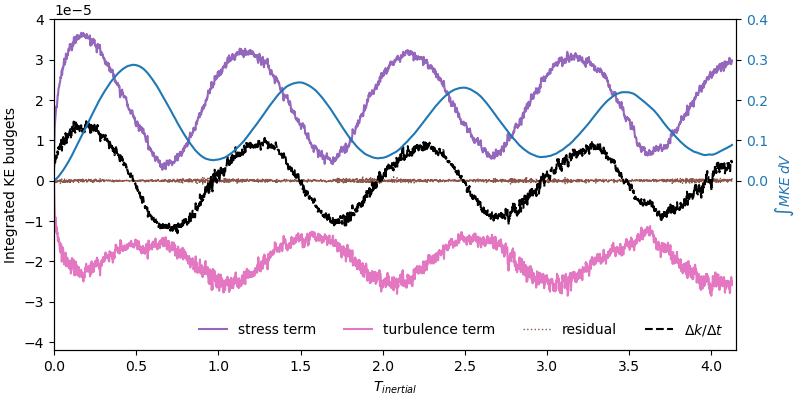

In [54]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)

itop = None
ds['IMKE'] = ds.IKE - ds.ITKE
ds['IMKE_stress_all'] = ds.IKE_stress_all - (ds.ITKE_Tsgs + ds.ITKE_dissipation)
ds['IMKE_turbulence'] = (ds.MKE_turbulence*deltaz).isel(zC=slice(None,itop)).sum('zC')

ds['dIMKE_dt'] = ds.IMKE.differentiate('time', datetime_unit='s')
ds['IMKE_residual'] = ds.dIMKE_dt + ds.IMKE_stress_all + ds.IMKE_turbulence

plt.plot(ds.timeTf, -ds.IMKE_stress_all, 'C4')
plt.plot(ds.timeTf, -ds.IMKE_turbulence, 'C6')
plt.plot(ds.timeTf, ds.IMKE_residual, ':C5', lw=1)
plt.plot(ds.timeTf, ds.dIMKE_dt, '--k')
plt.legend(['stress term', 'turbulence term', 'residual', r'$\Delta k/\Delta t$'],
           frameon=False, loc='lower right', ncol=4)
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated KE budgets')
plt.ylim(-4.2e-5, 4e-5)
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.xlim(0,4.15)

ax1 = plt.gca().twinx()
color = 'C0'
ax1.set_ylabel(r'$\int MKE \: dV$', color=color)
ax1.plot(ds.timeTf, ds.IMKE, color=color)
ax1.set_yticks(np.array([0, 1, 2, 3, 4])*1e-1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.42, 0.4);

# plt.savefig('../Figures/mwe_iMKE_budgets_'+case, dpi=250)

### Budgets for frontal zone simulations

In [47]:
cname = 's11_M030_Q000_W147_D270_St0_Vg0'

# dsa = xr.open_dataset(data_dir+cname+'_averages.nc')#.drop_vars(['uym','vym','wym','bym','cym'])
# dsa.close()
# dsa['timeTf'] = dsa.time/np.timedelta64(int(np.around(2*np.pi/dsa.f)), 's')
# dsa

dsh = xr.open_dataset(data_dir+cname+'_KE_budgets.nc')
dsh.close()
dsh['timeTf'] = dsh.time/np.timedelta64(int(np.around(2*np.pi/1e-4)), 's')
dsh

<xarray.Dataset> Size: 44MB
Dimensions:         (zC: 128, zF: 129, xC: 512, yF: 128, xF: 512, yC: 128,
                     time: 838)
Coordinates:
  * zC              (zC) float64 1kB -138.5 -135.4 -132.5 ... -0.7705 -0.2566
  * zF              (zF) float64 1kB -140.0 -136.9 -133.9 ... -1.028 -0.5132 0.0
  * xC              (xC) float64 4kB -499.0 -497.1 -495.1 ... 495.1 497.1 499.0
  * yF              (yF) float64 1kB 0.0 1.953 3.906 5.859 ... 244.1 246.1 248.0
  * xF              (xF) float64 4kB -500.0 -498.0 -496.1 ... 494.1 496.1 498.0
  * yC              (yC) float64 1kB 0.9766 2.93 4.883 ... 245.1 247.1 249.0
  * time            (time) timedelta64[ns] 7kB 00:00:00 ... 2 days 21:45:00
Data variables: (12/61)
    c               (time, zC) float64 858kB ...
    TKE_eps         (time, zC) float64 858kB ...
    MKE_tur         (time, zC) float64 858kB ...
    CKE_tur         (time, zC) float64 858kB ...
    b               (time, zC) float64 858kB ...
    wut             (time, zC) float64 858kB ...
    ...              ...
    MKE_stress_top  (time, zC) float64 858kB ...
    MKE_stress      (time, zC) float64 858kB ...
    CKE_stress_top  (time, zC) float64 858kB ...
    CKE_stress      (time, zC) float64 858kB ...
    CKE_GPW         (time, zC) float64 858kB ...
    timeTf          (time) float64 7kB 0.0 0.004775 0.009549 ... 3.992 3.996
Attributes:
    f:                     0.0001
    Dˢ:                    1
    viscosity_mol:         1e-06
    schedule:              TimeInterval
    interval:              300.0
    Julia:                 This file was generated using Julia Version 1.10.2...
    output time interval:  Output was saved every 5 minutes.
    Uˢ:                    0
    date:                  This file was generated on 2024-05-13T23:32:59.130.
    diffusivity_mol:       1.5e-07
    M²:                    3e-07
    Oceananigans:          This file was generated using Oceananigans v0.90.14

In [63]:
time_interval = (dsh.timeTf >= 8) & (dsh.timeTf < 9)

dsh.ITKE_GSP.where(time_interval).mean('time') / dsh.ITKE_ASP.where(time_interval).mean('time')

<xarray.DataArray ()> Size: 8B
array(-0.06962854)

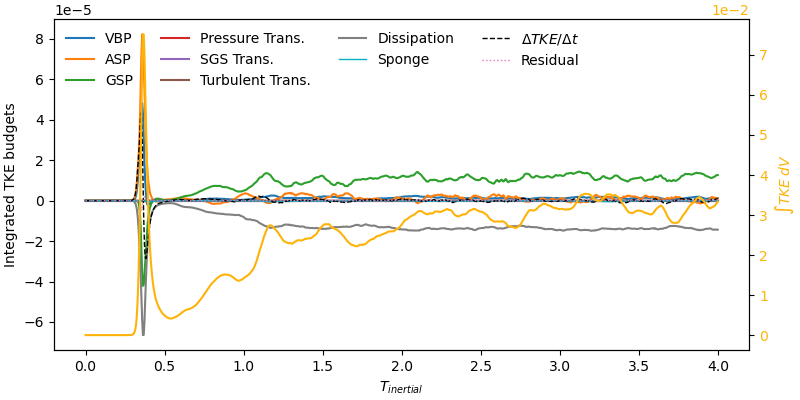

In [48]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)

deltaz = np.diff(dsh.zF)
itop = None
dsh['ITKE'] = (dsh.TKE*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_VBP'] = (dsh.wbt*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_ASP'] = (dsh.ASP*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_GSP'] = (dsh.GSP*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_prs'] = (dsh.TKE_prs*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_vis'] = (dsh.TKE_vis*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_tur'] = (dsh.TKE_tur*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_eps'] = (dsh.TKE_eps*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ITKE_spg'] = (dsh.TKE_spg*deltaz).isel(zC=slice(None,itop)).sum('zC')

dsh['dITKE_dt'] = dsh.ITKE.differentiate('time', datetime_unit='s')
dsh['ITKE_res'] = dsh.dITKE_dt - (dsh.ITKE_VBP + dsh.ITKE_ASP + dsh.ITKE_GSP -
                                  dsh.ITKE_prs - dsh.ITKE_vis - dsh.ITKE_tur -
                                  dsh.ITKE_eps + dsh.ITKE_spg)

plt.plot(dsh.timeTf,  dsh.ITKE_VBP);
plt.plot(dsh.timeTf,  dsh.ITKE_ASP);
plt.plot(dsh.timeTf,  dsh.ITKE_GSP);
plt.plot(dsh.timeTf, -dsh.ITKE_prs);
plt.plot(dsh.timeTf, -dsh.ITKE_vis);
plt.plot(dsh.timeTf, -dsh.ITKE_tur);
plt.plot(dsh.timeTf, -dsh.ITKE_eps, 'gray')
plt.plot(dsh.timeTf,  dsh.ITKE_spg, 'xkcd:turquoise blue', lw=1)
plt.plot(dsh.timeTf,  dsh.dITKE_dt, '--k', lw=1)
plt.plot(dsh.timeTf,  dsh.ITKE_res, ':', lw=1)
plt.legend(['VBP', 'ASP', 'GSP', 'Pressure Trans.', 'SGS Trans.', 'Turbulent Trans.',
            'Dissipation', 'Sponge', r'$\Delta TKE/\Delta t$', 'Residual'],
           frameon=False, ncol=4, loc='upper left')
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated TKE budgets')
# plt.ylim(-6e-7, 6e-7)
plt.ticklabel_format(axis='y', scilimits=(0,0))
# plt.xlim(0,4)

ax1 = plt.gca().twinx()
color = 'xkcd:amber'
ax1.set_ylabel(r'$\int TKE \: dV$', color=color)
ax1.plot(dsh.timeTf, dsh.ITKE, color=color)
# ax1.set_yticks(np.arange(0,7,2)*1e-3)
ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(axis='y', scilimits=(0,0))
# ax1.set_ylim(-6e-3, 6e-3);

# plt.savefig('../Figures/'+cname+'_iTKE_budgets', dpi=250)

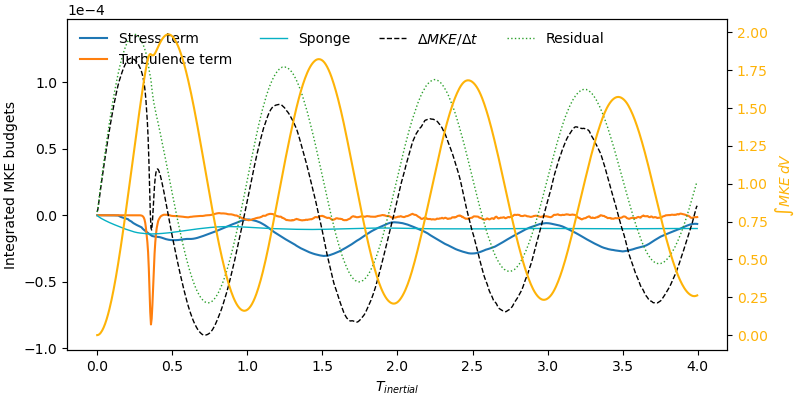

In [49]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)
time_interval = (dsh.timeTf >= 6) & (dsh.timeTf < 12)

itop = None
dsh['IMKE'] = (dsh.MKE*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['IMKE_sgs'] = (dsh.MKE_sgs*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['IMKE_stress_top'] = (dsh.MKE_stress_top*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['IMKE_tur'] = (dsh.MKE_tur*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['IMKE_stress'] = (dsh.MKE_stress*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['IMKE_spg'] = (dsh.MKE_spg*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['IMKE_eps'] = (dsh.MKE_eps*deltaz).isel(zC=slice(None,itop)).sum('zC')

dsh['dIMKE_dt'] = dsh.IMKE.differentiate('time', datetime_unit='s')
dsh['IMKE_res'] = dsh.dIMKE_dt - (- dsh.IMKE_stress - dsh.IMKE_tur + dsh.IMKE_spg)

plt.plot(dsh.timeTf, -dsh.IMKE_stress);
plt.plot(dsh.timeTf, -dsh.IMKE_tur);
# plt.plot(dsh.timeTf, -dsh.IMKE_eps, 'gray');
plt.plot(dsh.timeTf,  dsh.IMKE_spg, 'xkcd:turquoise blue', lw=1);
plt.plot(dsh.timeTf,  dsh.dIMKE_dt, '--k', lw=1)
plt.plot(dsh.timeTf,  dsh.IMKE_res, ':', lw=1)
plt.legend(['Stress term', 'Turbulence term', 'Sponge',
            r'$\Delta MKE/\Delta t$', 'Residual'],
           frameon=False, ncol=4, loc='upper left')
# plt.plot(dsh.timeTf, -dsh.ITKE_ASP, '--C1');
# plt.plot(dsh.timeTf, -dsh.ITKE_eps, '--', c='gray');
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated MKE budgets')
# plt.ylim(-2e-7, 3e-7)
plt.ticklabel_format(axis='y', scilimits=(0,0))
# plt.xlim(0,4)

ax1 = plt.gca().twinx()
color = 'xkcd:amber'
ax1.set_ylabel(r'$\int MKE \: dV$', color=color)
ax1.plot(dsh.timeTf, dsh.IMKE, color=color)
# ax1.set_yticks(np.arange(0,13,3)*1e-4)
ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(axis='y', scilimits=(0,0))
# ax1.set_ylim(-0.8e-3, 1.2e-3);

# plt.savefig('../Figures/'+cname+'_iMKE_budgets', dpi=250)

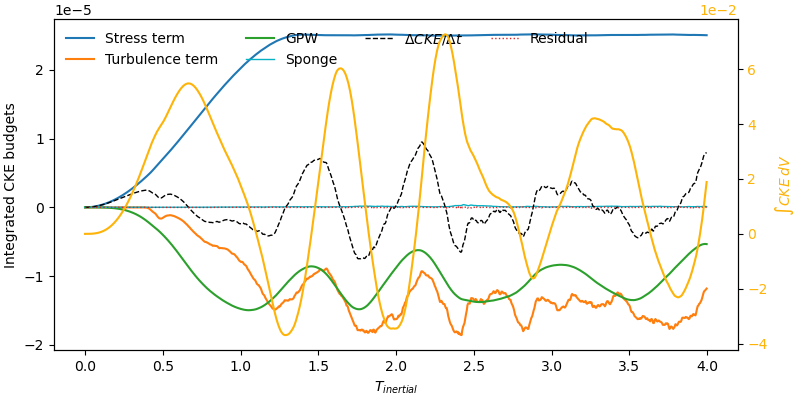

In [9]:
plt.close()
plt.figure(figsize=(8,4), constrained_layout=True)
time_interval = (dsh.timeTf >= 6) & (dsh.timeTf < 12)

itop = None
dsh['ICKE'] = (dsh.CKE*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_sgs'] = (dsh.CKE_sgs*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_stress_top'] = (dsh.CKE_stress_top*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_tur'] = (dsh.CKE_tur*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_stress'] = (dsh.CKE_stress*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_GPW'] = (dsh.CKE_GPW*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_spg'] = (dsh.CKE_spg*deltaz).isel(zC=slice(None,itop)).sum('zC')
dsh['ICKE_eps'] = (dsh.CKE_eps*deltaz).isel(zC=slice(None,itop)).sum('zC')

dsh['dICKE_dt'] = dsh.ICKE.differentiate('time', datetime_unit='s')
dsh['ICKE_res'] = dsh.dICKE_dt - (dsh.ICKE_GPW - dsh.ICKE_stress - dsh.ICKE_tur + dsh.ICKE_spg)

plt.plot(dsh.timeTf, -dsh.ICKE_stress);
plt.plot(dsh.timeTf, -dsh.ICKE_tur);
plt.plot(dsh.timeTf,  dsh.ICKE_GPW);
# plt.plot(dsh.timeTf, -dsh.ICKE_eps, 'gray')
plt.plot(dsh.timeTf,  dsh.ICKE_spg, 'xkcd:turquoise blue', lw=1)
plt.plot(dsh.timeTf,  dsh.dICKE_dt, '--k', lw=1)
plt.plot(dsh.timeTf,  dsh.ICKE_res, ':', lw=1)
plt.legend(['Stress term', 'Turbulence term', 'GPW', 'Sponge',
            r'$\Delta CKE/\Delta t$', 'Residual'],
           frameon=False, ncol=4, loc='upper left')
plt.xlabel(r'$T_{inertial}$')
plt.ylabel('Integrated CKE budgets')
# plt.ylim(-7e-7, 8e-7)
plt.ticklabel_format(axis='y', scilimits=(0,0))
# plt.xlim(0,4)

ax1 = plt.gca().twinx()
color = 'xkcd:amber'
ax1.set_ylabel(r'$\int CKE \: dV$', color=color)
ax1.plot(dsh.timeTf, dsh.ICKE, color=color)
# ax1.set_yticks(np.arange(0,10,2)*1e-3)
ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(axis='y', scilimits=(0,0))
# ax1.set_ylim(-7e-3, 8e-3);

# plt.savefig('../Figures/'+cname+'_iCKE_budgets', dpi=250)

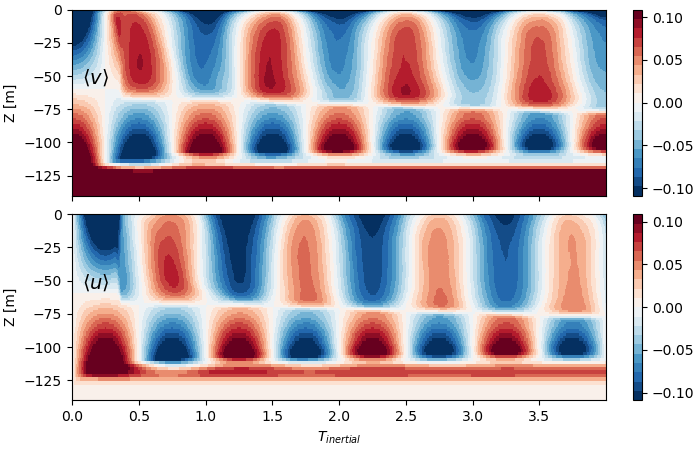

In [56]:
plt.close()
plt.figure(figsize=(7,4.5), constrained_layout=True)
bkw = dict(colors='k', linewidths=0.3)
vlim = np.maximum(np.abs(dsh.u.quantile(0.03)), np.abs(dsh.u.quantile(0.97)))
kw = dict(cmap=plt.get_cmap('RdBu_r', 20), vmin=-vlim, vmax=vlim)

plt.subplot(211)
plt.pcolormesh(dsh.timeTf, dsh.zC, (dsh.v+dsh.Vbak).T, **kw)
plt.colorbar()
# plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.arange(0,2.6,0.02)*1e-2, **bkw)
plt.text(0.02,0.6, r'$\langle v \rangle$', fontsize=14, transform=plt.gca().transAxes)
plt.gca().set_xticklabels([])
plt.ylabel('Z [m]')
plt.ylim(-140,0)
# plt.xlim(0,4)

plt.subplot(212)
plt.pcolormesh(dsh.timeTf, dsh.zC, dsh.u.T, **kw)
plt.colorbar()
# plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.arange(0,2.6,0.02)*1e-2, **bkw)
plt.text(0.02,0.6, r'$\langle u \rangle$', fontsize=14, transform=plt.gca().transAxes)
plt.ylabel('Z [m]')
plt.xlabel(r'$T_{inertial}$')
plt.ylim(-140,0);
# plt.xlim(0,4);

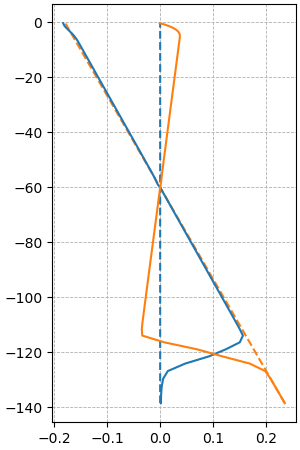

In [64]:
plt.close()
plt.figure(figsize=(3,4.5), constrained_layout=True)

i=60
plt.plot((dsh.u).isel(time=0), dsh.zC, '--')
plt.plot((dsh.v+dsh.Vbak).isel(time=0), dsh.zC, '--');
plt.grid('on', ls='--', lw=0.6)
plt.gca().set_prop_cycle(None)
plt.plot((dsh.u).isel(time=i), dsh.zC)
plt.plot((dsh.v+dsh.Vbak).isel(time=i), dsh.zC);


(-105.0, 0.0)

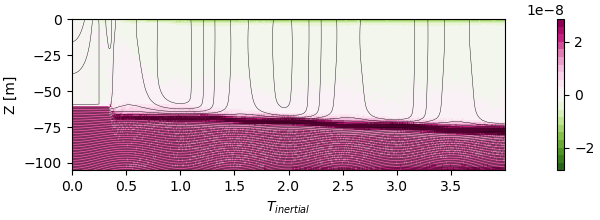

In [53]:
plt.close()
plt.figure(figsize=(6,2.2), constrained_layout=True)
bkw = dict(colors='k', linewidths=0.3)
var = 'q'
vlim = np.maximum(np.abs(dsh[var].quantile(0.02)), np.abs(dsh[var].quantile(0.98)))
kw = dict(cmap=plt.get_cmap('PiYG_r', 20), vmin=-vlim, vmax=vlim)
_, zvar = sorted(dsh[var].dims)

plt.pcolormesh(dsh.timeTf, dsh[zvar], dsh[var].T, **kw)
plt.colorbar()
plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.arange(0,2.6,0.02)*1e-2, **bkw)
# plt.contour(dsh.timeTf, dsh[zvar], dsh[var].T, [0], colors='C0', linewidths=0.5)

plt.ylabel('Z [m]')
plt.xlabel(r'$T_{inertial}$')
plt.ylim(-105,0)
# plt.xlim(0,4);

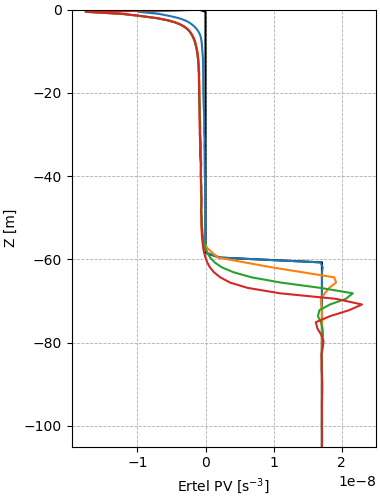

In [12]:
plt.close()
plt.figure(figsize=(3.8,5), constrained_layout=True)

plt.plot(dsh.q.isel(time=0), dsh.zF, 'k')

time_interval = (dsh.timeTf >= 0) & (dsh.timeTf < 1)
plt.plot(dsh.q.where(time_interval).mean('time'), dsh.zF)
time_interval = (dsh.timeTf >= 1) & (dsh.timeTf < 2)
plt.plot(dsh.q.where(time_interval).mean('time'), dsh.zF)
time_interval = (dsh.timeTf >= 2) & (dsh.timeTf < 3)
plt.plot(dsh.q.where(time_interval).mean('time'), dsh.zF)
time_interval = (dsh.timeTf >= 3) & (dsh.timeTf < 4)
plt.plot(dsh.q.where(time_interval).mean('time'), dsh.zF)
time_interval = (dsh.timeTf >= 4) & (dsh.timeTf < 5)
plt.plot(dsh.q.where(time_interval).mean('time'), dsh.zF)

plt.grid('on', ls='--', lw=0.6)
plt.ylim(-105, 0)
plt.ylabel('Z [m]');
plt.xlabel(r'Ertel PV [s$^{-3}$]');

#### Reynolds stress

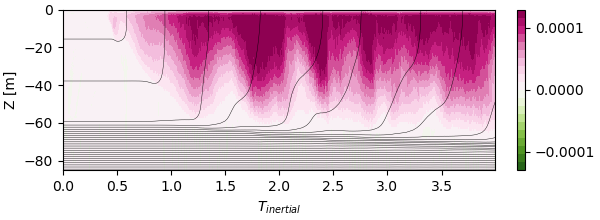

In [14]:
plt.close()
plt.figure(figsize=(6,2.2), constrained_layout=True)
bkw = dict(colors='k', linewidths=0.3)
var = 'wvt'
vlim = np.maximum(np.abs(dsh[var].quantile(0.02)), np.abs(dsh[var].quantile(0.98)))
kw = dict(cmap=plt.get_cmap('PiYG_r', 20), vmin=-vlim, vmax=vlim)
_, zvar = sorted(dsh[var].dims)

plt.pcolormesh(dsh.timeTf, dsh[zvar], dsh[var].T, **kw)
plt.colorbar()
plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.arange(0,2.6,0.02)*1e-2, **bkw)
# plt.contour(dsh.timeTf, dsh[zvar], dsh[var].T, [0], colors='C0', linewidths=0.5)

plt.ylabel('Z [m]')
plt.xlabel(r'$T_{inertial}$')
plt.ylim(-85,0);
# plt.xlim(0,4);

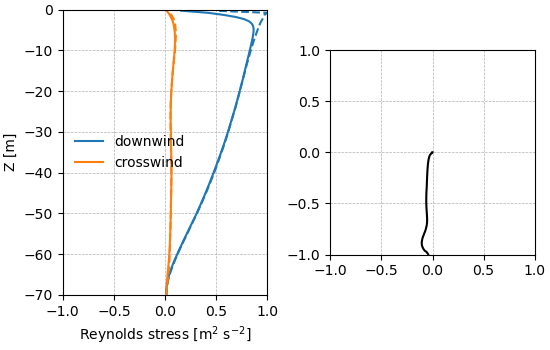

In [36]:
plt.close()
fig = plt.figure(figsize=(5.5,3.5), constrained_layout=True)
gs  = gridspec.GridSpec(1, 10, figure=fig)
time_interval = (dsh.timeTf >= 3) & (dsh.timeTf < 4)
ustar2 = np.sqrt(dsh.Qu**2 + dsh.Qv**2)

ax1 = fig.add_subplot(gs[0, :5])
plt.plot((dsh.wvt/ustar2).where(time_interval).mean(['time']), dsh.zC)
plt.plot((dsh.wut/ustar2).where(time_interval).mean(['time']), dsh.zC)
plt.gca().set_prop_cycle(None)
plt.plot(((dsh.wvt + dsh.wvsgs)/ustar2).where(time_interval).mean(['time']), dsh.zC, '--')
plt.plot(((dsh.wut + dsh.wusgs)/ustar2).where(time_interval).mean(['time']), dsh.zC, '--')
plt.legend(['downwind', 'crosswind'], frameon=False)
plt.grid('on', ls='--', lw=0.5)
plt.ylim(-70, 0)
plt.xlim(-1,1)
plt.ylabel('Z [m]');
plt.xlabel(r'Reynolds stress [m$^2$ s$^{-2}$]');

ax2 = fig.add_subplot(gs[0, 5:])
# plt.plot(-(dsh.wut/ustar2).where(time_interval).mean(['time']), -(dsh.wvt/ustar2).where(time_interval).mean(['time']))
plt.plot(-((dsh.wut + dsh.wusgs)/ustar2).where(time_interval).mean(['time'])[:-1], 
         -((dsh.wvt + dsh.wvsgs)/ustar2).where(time_interval).mean(['time'])[:-1], 'k')
plt.grid('on', ls='--', lw=0.5)
ax2.set_aspect('equal', 'box')
plt.xlim(-1,1)
plt.ylim(-1,1);

#### Dissipation

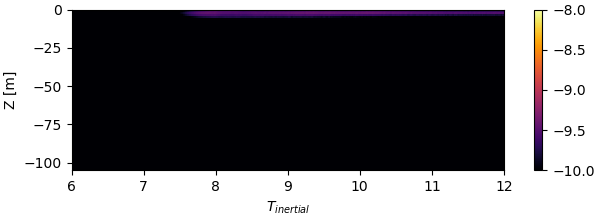

In [35]:
plt.close()
plt.figure(figsize=(6,2.2), constrained_layout=True)
bkw = dict(colors='k', linewidths=0.3)
kw = dict(cmap='inferno', vmin=-10, vmax=-8)

plt.pcolormesh(dsh.timeTf, dsh.zC, np.log10(dsh.eps).T, **kw)
plt.colorbar()
plt.contour(dsh.timeTf, dsh.zC, dsh.b.T, np.arange(0,2.6,0.02)*1e-4, **bkw)

plt.ylabel('Z [m]')
plt.xlabel(r'$T_{inertial}$')
plt.ylim(-105,0)
plt.xlim(6,12);

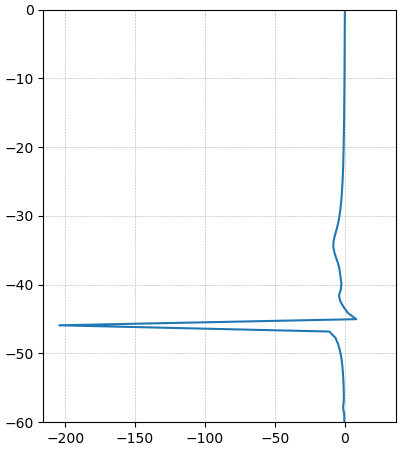

In [15]:
plt.close()
fig = plt.figure(figsize=(4,4.5), constrained_layout=True)
time_interval = (dsh.timeTf >= 8) & (dsh.timeTf < 9)

plt.plot(-dsh.wbt.where(time_interval).mean(['time']) / (dsh.GSP).where(time_interval).mean(['time']), dsh.zC)
plt.grid('on', ls='--', lw=0.4)
plt.ylim(-60, 0);
# plt.xlim(-0.5, 0.5);

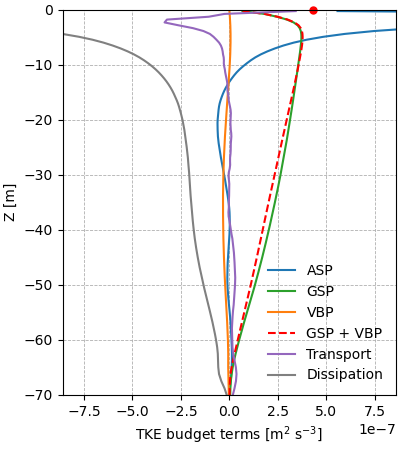

In [41]:
plt.close()
fig = plt.figure(figsize=(4,4.5), constrained_layout=True)
time_interval = (dsh.timeTf >= 3) & (dsh.timeTf < 4)

EBF = dsh.Qv.where(time_interval).mean('time')*dsh.attrs['M²']/dsh.f
plt.plot(dsh.ASP.where(time_interval).mean(['time']), dsh.zC)
# plt.plot(dsh.SSP.where(time_interval).mean(['time']), dsh.zC)
plt.plot(dsh.GSP.where(time_interval).mean(['time']), dsh.zC, 'C2')
plt.plot(dsh.wbt.where(time_interval).mean(['time']), dsh.zC, 'C1')
plt.plot((dsh.GSP+dsh.wbt).where(time_interval).mean(['time']), dsh.zC, '--r')
plt.plot(-(dsh.TKE_tur+dsh.TKE_prs+dsh.TKE_vis).where(time_interval).mean(['time']), dsh.zC, 'C4')
plt.plot(-dsh.TKE_eps.where(time_interval).mean(['time']), dsh.zC, 'gray')
plt.plot(EBF, 0, 'or', markersize=5, clip_on=False)
plt.xlim(-np.abs(EBF)*2,np.abs(EBF)*2)

# plt.xlim(-4e-8,4e-8)
# plt.xlim(-1.2e-9,1.5e-9)

# plt.plot(dsh.wut.where(time_interval).mean(['time'])/(0.037/1026), dsh.zC);
# plt.plot(dsh.wvt.where(time_interval).mean(['time'])/(0.037/1026), dsh.zC);
# plt.xlim(-1, 0.3)
# plt.xlabel(r"$\overline{w'u'}$, $\overline{w'v'}$ / $u^2_*$", fontsize=12);

# plt.plot(dsh.u.where(time_interval).mean(['time']), dsh.zC, '.-');
# plt.plot(dsh.v.where(time_interval).mean(['time']), dsh.zC, '.-');
# plt.plot(dsh.dVdz, dsh.zC);

plt.legend(['ASP', 'GSP', 'VBP', 'GSP + VBP', 'Transport', 'Dissipation'], frameon=False, 
           loc='lower right')
plt.grid('on', ls='--', lw=0.6)
plt.ylim(-70, 0)
plt.ylabel('Z [m]');
plt.xlabel(r'TKE budget terms [m$^2$ s$^{-3}$]');

# plt.savefig('../Figures/'+cname+'_TKE_budgets', dpi=250)

In [42]:
periodic_coords = {dim : dict(left=f'{dim}F', center=f'{dim}C') for dim in 'z'}
bounded_coords = {dim : dict(outer=f'{dim}F', center=f'{dim}C') for dim in 'z'}
coords = {dim : periodic_coords[dim] if tpl=='P' else bounded_coords[dim] for dim, tpl in zip('z', 'N')}
grid = Grid(dsh, coords=coords, periodic=['x', 'y'])
dzF = dsh.zF.diff('zF').data

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    wut_f = grid.interp(dsh.wut, axis='z', boundary='fill', fill_value=0) ## ?
    wvt_f = grid.interp(dsh.wvt, axis='z', boundary='fill', fill_value=0) ## ?
    wbt_f = grid.interp(dsh.wbt, axis='z', boundary='fill', fill_value=0)
    dsh['dwutdz'] = grid.diff(wut_f, axis='z') / dzF
    dsh['dwvtdz'] = grid.diff(wvt_f, axis='z') / dzF
    dsh['dwbtdz'] = grid.diff(wbt_f, axis='z') / dzF

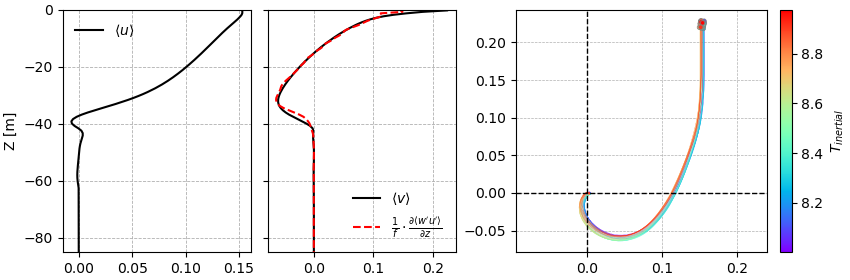

In [44]:
plt.close()
fig = plt.figure(figsize=(8.5,2.8), constrained_layout=True)
gs = gridspec.GridSpec(1, 10, figure=fig)

time_interval = (dsh.timeTf >= 8) & (dsh.timeTf < 9)

ax1 = fig.add_subplot(gs[0, :3])
plt.plot(dsh.u.where(time_interval).mean(['time']), dsh.zC, 'k')
# plt.plot(-dsh.dwvtdz.where(time_interval).mean(['time'])/1e-4, dsh.zC, '--r')
plt.grid('on', ls='--', lw=0.6)
plt.legend([r'$\langle u \rangle$', r"$\frac{-1}{f} \cdot \frac{\partial \langle w'v' \rangle}{\partial z}$"],
           frameon=False)
plt.ylim(-85, 0)
# plt.xlim(-0.05, 0.03)
plt.ylabel('Z [m]');

ax2 = fig.add_subplot(gs[0, 3:6])
plt.plot(dsh.v.where(time_interval).mean(['time']), dsh.zC, 'k')
plt.plot(dsh.dwutdz.where(time_interval).mean(['time'])/1e-4, dsh.zC, '--r')
plt.grid('on', ls='--', lw=0.6)
plt.legend([r'$\langle v \rangle$', r"$\frac{1}{f} \cdot \frac{\partial \langle w'u' \rangle}{\partial z}$"],
           frameon=False)
plt.gca().set_yticklabels([])
plt.ylim(-85, 0)
# plt.xlim(-0.05, 0.03);

ax3 = fig.add_subplot(gs[0, 6:])
tmp = dsh.where(time_interval, drop=True)
nc = tmp.sizes['time']
colors = plt.cm.rainbow(np.linspace(0,1,nc))
for i in range(0,nc,3):
    u = tmp.u.isel(time=i).sel(zC=slice(-110,0))
    v = tmp.v.isel(time=i).sel(zC=slice(-110,0))
    plt.plot(u, v, c=colors[i], lw=0.2)
sc = plt.scatter(tmp.u.sel(zC=0, method='nearest').thin(3), 
                 tmp.v.sel(zC=0, method='nearest').thin(3), 10, c=tmp.timeTf.thin(3),
                 cmap='rainbow', edgecolor='gray', lw=0.5, zorder=3)
cb = plt.colorbar(sc)
cb.set_label(r'$T_{inertial}$')
# plt.plot(dsh.u.where(time_interval).mean(['time']), dsh.v.where(time_interval).mean(['time']))
plt.axhline(0, c='k', ls='--', lw=1)
plt.axvline(0, c='k', ls='--', lw=1)
plt.gca().set_aspect('equal', 'box')
plt.grid('on', ls='--', lw=0.5)
plt.axis('equal');

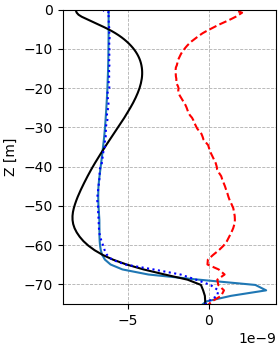

In [46]:
plt.close()
fig = plt.figure(figsize=(2.8,3.5), constrained_layout=True)
time_interval = (dsh.timeTf >= 3) & (dsh.timeTf < 4)
dshb = dsh.b.where(time_interval, drop=True).isel(time=[0,-1]).T

plt.plot(dshb.diff('time')/dshb.time.diff('time').dt.seconds, dsh.zC)
plt.plot(dsh.attrs['M²']*dsh.u.where(time_interval).mean(['time']), dsh.zC, 'k')
plt.plot(-dsh.dwbtdz.where(time_interval).mean(['time']), dsh.zC, '--r')
plt.plot(-dsh.dwbtdz.where(time_interval).mean(['time']) + dsh.attrs['M²']*dsh.u.where(time_interval).mean(['time']), dsh.zC, ':b')
plt.grid('on', ls='--', lw=0.6)
# plt.legend([r'$\frac{\partial \langle b \rangle}{\partial t}$', r'$-\langle u \rangle M^2$',
#             r"$-\frac{\partial \langle w'b' \rangle}{\partial z}$"])
plt.ylim(-75, 0)
plt.ylabel('Z [m]');